In [1]:
import sys; sys.path.insert(0, '../../')

# Disable GPU to prevent TensorFlow/nengo_dl crashes when CUDA is unavailable
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
print("TensorFlow running on CPU only")

2026-01-19 16:58:18.572727: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-19 16:58:19.103431: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2026-01-19 16:58:19.103529: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2026-01-19 16:58:20.190127: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2026-

TensorFlow running on CPU only


2026-01-19 16:58:21.712641: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2026-01-19 16:58:21.712714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-PH8A95A): /proc/driver/nvidia/version does not exist


In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
from models.snn.factory import build_snn, build_simple_snn
from models.snn.train import train_model, evaluate_model
from models.snn.tuning import tune_hyperparameters
from models.preprocessing import load_preprocessed, downsample_features

TensorFlow running on CPU only


2026-01-19 16:58:22.517737: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2026-01-19 16:58:23.168355: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2026-01-19 16:58:23.168452: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2026-01-19 16:58:23.168463: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

In [ ]:
splits, class_names = load_preprocessed('../../data/processed/')
X_train_full, y_train = splits['train']
X_val_full, y_val = splits['val']
X_test_full, y_test = splits['test']

# Downsample from 640x480 to 128x96 for SNN
TARGET_WIDTH = 128
TARGET_HEIGHT = 96
print(f"Downsampling features from 640x480 to {TARGET_WIDTH}x{TARGET_HEIGHT}...")

X_train = downsample_features(X_train_full, target_width=TARGET_WIDTH, target_height=TARGET_HEIGHT)
X_val = downsample_features(X_val_full, target_width=TARGET_WIDTH, target_height=TARGET_HEIGHT)
X_test = downsample_features(X_test_full, target_width=TARGET_WIDTH, target_height=TARGET_HEIGHT)

print(f"  Train: {X_train_full.shape} -> {X_train.shape}")
print(f"  Val:   {X_val_full.shape} -> {X_val.shape}")
print(f"  Test:  {X_test_full.shape} -> {X_test.shape}")

# Free memory from full-resolution arrays
del X_train_full, X_val_full, X_test_full

Loaded train: X=(1672, 30720), y=(1672, 3)
Loaded val: X=(479, 30720), y=(479, 3)
Loaded test: X=(239, 30720), y=(239, 3)
Loaded class names: ['mark', 'marvin', 'yannes']


In [4]:
checkpoint_dir = Path('../../checkpoints/snn')
env_path = checkpoint_dir / "best_hparams.env"

In [5]:
# Load hyperparameters from env file if it exists, otherwise use defaults
if env_path.exists():
    print(f"Loading hyperparameters from {env_path}")
    hparams = {}
    with env_path.open("r") as f:
        for line in f:
            line = line.strip()
            if line and '=' in line:
                key, value = line.split('=', 1)
                hparams[key] = value
    
    best_hidden = int(hparams.get('N_NEURONS_HIDDEN', 128))
    best_lr = float(hparams.get('LEARNING_RATE', 0.001))
    best_batch_sz = int(hparams.get('BATCH_SIZE', 32))
    best_wd = float(hparams.get('WEIGHT_DECAY', 0.0))
    best_homogeneous = bool(int(hparams.get('HOMOGENEOUS', 1)))
    best_spiking = bool(int(hparams.get('SPIKING', 0)))
    
    print("Loaded hyperparameters:")
else:
    print(f"Env file not found at {env_path}, using default hyperparameters")
    best_hidden = 128
    best_lr = 0.001
    best_wd = 0.0
    best_batch_sz = 32
    best_homogeneous = True
    best_spiking = False
    
    print("Using default hyperparameters:")

print(f"  Hidden neurons: {best_hidden}")
print(f"  Learning rate: {best_lr:.2e}")
print(f"  Batch size: {best_batch_sz}")
print(f"  Weight decay: {best_wd:.2e}")
print(f"  Homogeneous: {best_homogeneous}")
print(f"  Spiking: {best_spiking}")

Loading hyperparameters from ../../checkpoints/snn/best_hparams.env
Loaded hyperparameters:
  Hidden neurons: 89
  Learning rate: 1.08e-04
  Batch size: 64
  Weight decay: 1.30e-05
  Homogeneous: True
  Spiking: False


In [6]:
print("Building SNN architecture...")
net, inp, p_out = build_simple_snn(
    n_features=X_train.shape[1],
    n_classes=len(class_names),
    n_neurons_hidden=best_hidden,  # Hidden layer neurons
    synapse=None,          # No synaptic filtering for single timestep
    spiking=best_spiking,         # Use RectifiedLinear neurons (trainable)
    homogeneous=best_homogeneous  # Homogeneous or heterogeneous neurons
)
print(f"Network built with {X_train.shape[1]} input features and {len(class_names)} output classes")
print(f"Using rate-based neurons (RectifiedLinear) for gradient-based training")

Building SNN architecture...
Network built with 30720 input features and 3 output classes
Using rate-based neurons (RectifiedLinear) for gradient-based training


In [7]:
# Train the SNN with best hyperparameters from tuning
print("Starting full training with best hyperparameters...")
print(f"Learning rate: {best_lr:.2e}, Batch size: {best_batch_sz}\n")

history, sim = train_model(
    net=net,
    inp=inp,
    p_out=p_out,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=100,
    batch_size=best_batch_sz,
    learning_rate=best_lr,
    weight_decay=best_wd,
    checkpoint_dir=checkpoint_dir,
    use_early_stopping=False,
    early_stopping_min_delta=0.001,
    early_stopping_patience=10,
)

Starting full training with best hyperparameters...
Learning rate: 1.08e-04, Batch size: 64

Creating simulator...
|                     Building network (0%)                    | ETA:  --:--:--
|#####################Building network (42%)                     | ETA: 0:00:00
Build finished in 0:00:00
|#                         Optimizing graph                           | 0:00:00
|#             Optimizing graph: operator simplificaton               | 0:00:00
Optimizing graph: operator simplificaton finished in 0:00:00
|#                Optimizing graph: merging operators                 | 0:00:00
Optimizing graph: merging operators finished in 0:00:00
|#                Optimizing graph: ordering signals                  | 0:00:00
Optimizing graph: ordering signals finished in 0:00:00
|#                Optimizing graph: creating signals                  | 0:00:00
Optimizing graph: creating signals finished in 0:00:00
Optimization finished in 0:00:00
|#                        Constructing 

/home/raah/.local/share/virtualenvs/neuro-ai-9gzpYvh7/lib/python3.10/site-packages/nengo_dl/simulator.py:456: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(
2026-01-19 16:58:27.037991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


| #                       Constructing graph                          | 0:00:00
Constructing graph: build stage finished in 0:00:00
Construction finished in 0:00:00
Compiling model...
  Using AdamW optimizer with weight_decay=1.3000698177744616e-05

Training for 100 epochs...
  Input shape: (1672, 1, 30720)
  Label shape: (1672, 1, 3)
Epoch 1/100
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
Constructing graph: build stage finished in 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
Constructing graph: build stage finished in 0:00:00
1670/1672 [============================>.] - ETA: 0s - loss: 1.7331 - probe_loss: 1.7331 - probe_accuracy: 0.4395| 

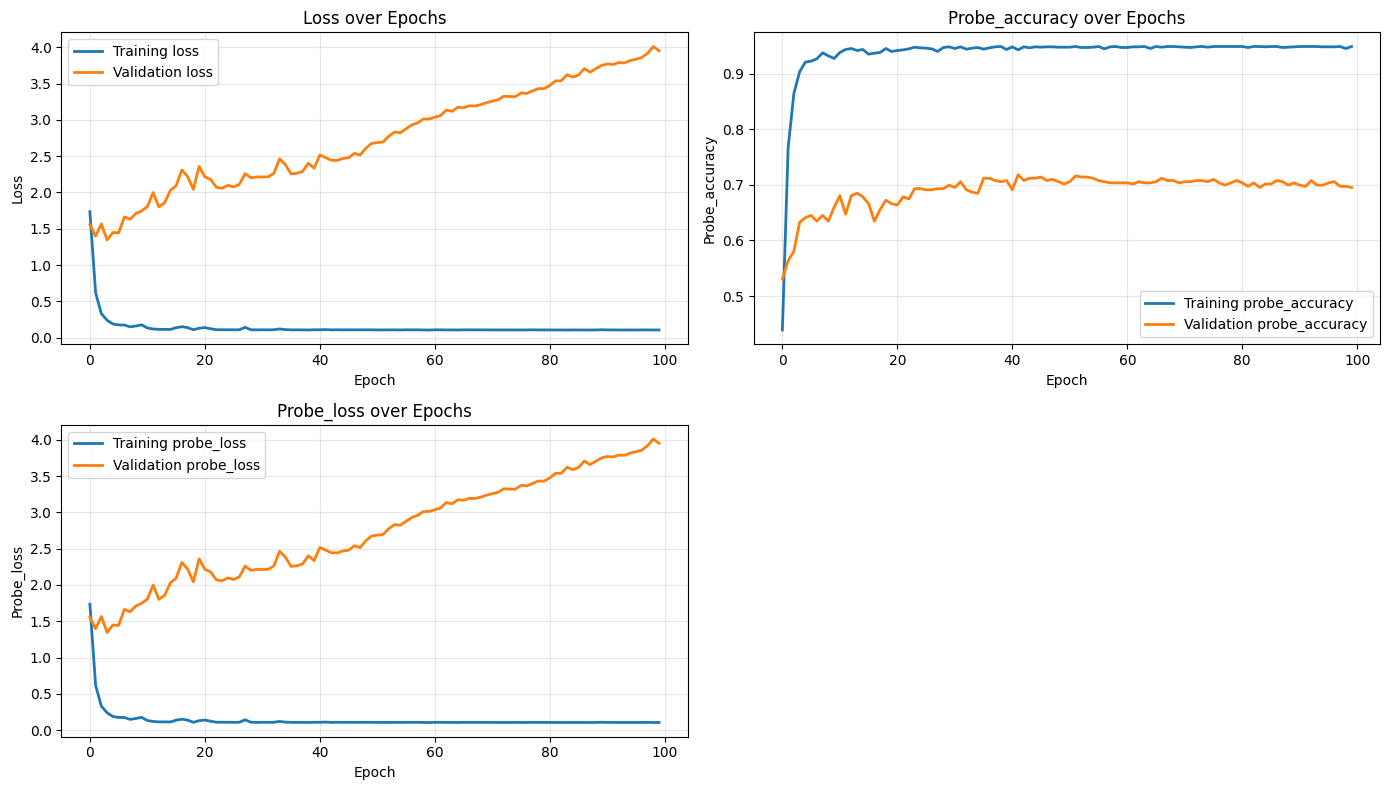


Available metrics in history:
  loss: min=0.1059, max=1.7354, final=0.1070
  probe_accuracy: min=0.4390, max=0.9486, final=0.9486
  probe_loss: min=0.1059, max=1.7354, final=0.1070
  val_loss: min=1.3464, max=4.0093, final=3.9516
  val_probe_accuracy: min=0.5303, max=0.7182, final=0.6952
  val_probe_loss: min=1.3464, max=4.0093, final=3.9516


In [8]:
# Get all unique metric names (without 'val_' prefix)
metrics = set()
for key in history.history.keys():
    metric_name = key.replace('val_', '')
    metrics.add(metric_name)

metrics = sorted(list(metrics))

# Create subplots for each metric
n_metrics = len(metrics)
n_cols = 2
n_rows = (n_metrics + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
if n_metrics == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# Plot each metric
for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    # Training metric
    if metric in history.history:
        ax.plot(history.history[metric], label=f'Training {metric}', linewidth=2)
    
    # Validation metric
    val_metric = f'val_{metric}'
    if val_metric in history.history:
        ax.plot(history.history[val_metric], label=f'Validation {metric}', linewidth=2)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'{metric.capitalize()} over Epochs')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(len(metrics), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

# Print summary of all metrics
print("\nAvailable metrics in history:")
for key in sorted(history.history.keys()):
    values = history.history[key]
    print(f"  {key}: min={min(values):.4f}, max={max(values):.4f}, final={values[-1]:.4f}")


Evaluating on test set...
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
Constructing graph: build stage finished in 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
Constructing graph: build stage finished in 0:00:00
239/239 [==============================] - 1s 2ms/step - loss: 6.6532 - probe_loss: 6.6532 - probe_accuracy: 0.5941
Test Loss: 6.6532
Test Accuracy: 0.5941

Computing confusion matrix...
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
Constructing graph: build stage fi

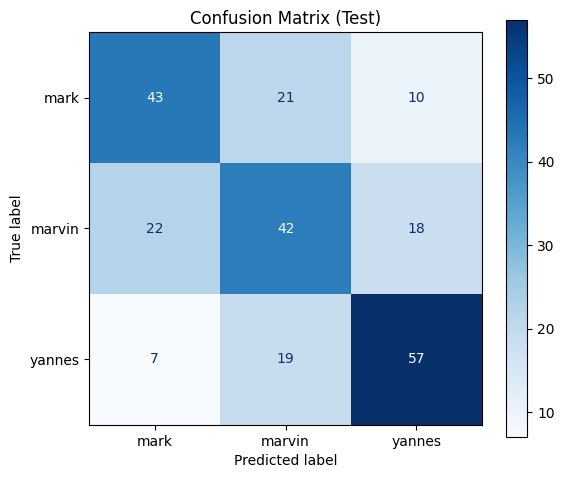


Classification report (Test):
              precision    recall  f1-score   support

        mark     0.5972    0.5811    0.5890        74
      marvin     0.5122    0.5122    0.5122        82
      yannes     0.6706    0.6867    0.6786        83

    accuracy                         0.5941       239
   macro avg     0.5933    0.5933    0.5933       239
weighted avg     0.5935    0.5941    0.5938       239



In [9]:
# Evaluate on test set + confusion matrix
import numpy as np
from scipy.special import softmax

print("\nEvaluating on test set...")
test_results = evaluate_model(sim, inp, p_out, X_test, y_test)

# Find the accuracy key (it will contain 'accuracy' in the name)
accuracy_key = [k for k in test_results.keys() if 'accuracy' in k][0]

print(f"Test Loss: {test_results['loss']:.4f}")
print(f"Test Accuracy: {test_results[accuracy_key]:.4f}")

print("\nComputing confusion matrix...")

# Predict class logits on the test set
X_test_reshaped = X_test[:, np.newaxis, :]
pred_out = sim.predict({inp: X_test_reshaped})
logits_time = pred_out[p_out]

# Handle both (batch, time, classes) and (batch, classes)
if logits_time.ndim == 3:
    logits = logits_time[:, -1, :]
elif logits_time.ndim == 2:
    logits = logits_time
else:
    raise ValueError(f"Unexpected model output shape for p_out: {logits_time.shape}")

# Apply softmax to get probabilities (network outputs raw logits now)
probs = softmax(logits, axis=1)
y_pred = np.argmax(probs, axis=1)

# y_test is usually one-hot encoded; support both one-hot and integer labels
if y_test.ndim == 2:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test.astype(int)

n_classes = len(class_names)
labels = list(range(n_classes))

# Prefer sklearn if available (nicer plotting + report), else fallback to numpy
try:
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

    cm = confusion_matrix(y_true, y_pred, labels=labels)

    fig, ax = plt.subplots(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format="d")
    ax.set_title("Confusion Matrix (Test)")
    plt.tight_layout()
    plt.show()

    print("\nClassification report (Test):")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

except Exception as e:
    print(f"(sklearn unavailable or failed: {e})\nFalling back to numpy confusion matrix plot.")

    cm = np.zeros((n_classes, n_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        if 0 <= t < n_classes and 0 <= p < n_classes:
            cm[t, p] += 1

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title("Confusion Matrix (Test)")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(n_classes))
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names)

    # annotate counts
    for i in range(n_classes):
        for j in range(n_classes):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center", color="black")

    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

=== Uncertainty Analysis (threshold=50%) ===

Total predictions: 239
Confident (≥50%): 238 (99.6%)
Uncertain (<50%): 1 (0.4%)

Accuracy on confident predictions: 0.5966
Confident but wrong: 96/238 (40.3%)

Accuracy on uncertain predictions (if not rejected): 0.0000

=== Per-class confidence breakdown ===
mark: 74/74 confident (100.0%), avg prob: 0.914
marvin: 81/82 confident (98.8%), avg prob: 0.906
yannes: 83/83 confident (100.0%), avg prob: 0.927


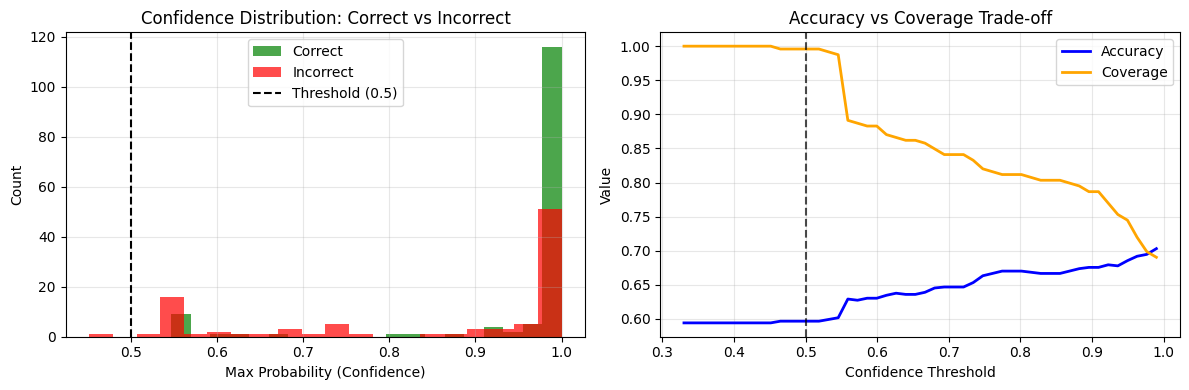

In [10]:
# Uncertainty threshold analysis
CONFIDENCE_THRESHOLD = 0.5

max_probs = np.max(probs, axis=1)
confident_mask = max_probs >= CONFIDENCE_THRESHOLD

confident_preds = y_pred[confident_mask]
confident_true = y_true[confident_mask]
uncertain_preds = y_pred[~confident_mask]
uncertain_true = y_true[~confident_mask]

print(f"=== Uncertainty Analysis (threshold={CONFIDENCE_THRESHOLD*100:.0f}%) ===\n")
print(f"Total predictions: {len(y_test)}")
print(f"Confident (≥{CONFIDENCE_THRESHOLD*100:.0f}%): {confident_mask.sum()} ({100*confident_mask.mean():.1f}%)")
print(f"Uncertain (<{CONFIDENCE_THRESHOLD*100:.0f}%): {(~confident_mask).sum()} ({100*(~confident_mask).mean():.1f}%)")

if confident_mask.sum() > 0:
    confident_acc = (confident_preds == confident_true).mean()
    print(f"\nAccuracy on confident predictions: {confident_acc:.4f}")
    
    # How many confident predictions are wrong?
    confident_wrong = (confident_preds != confident_true).sum()
    print(f"Confident but wrong: {confident_wrong}/{confident_mask.sum()} ({100*confident_wrong/confident_mask.sum():.1f}%)")

if (~confident_mask).sum() > 0:
    uncertain_acc = (uncertain_preds == uncertain_true).mean()
    print(f"\nAccuracy on uncertain predictions (if not rejected): {uncertain_acc:.4f}")

# Breakdown by class
print(f"\n=== Per-class confidence breakdown ===")
for i, name in enumerate(class_names):
    class_mask = y_true == i
    class_confident = confident_mask[class_mask]
    class_probs = max_probs[class_mask]
    print(f"{name}: {class_confident.sum()}/{class_mask.sum()} confident "
          f"({100*class_confident.mean():.1f}%), avg prob: {class_probs.mean():.3f}")

# Plot confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of max probabilities
ax = axes[0]
ax.hist(max_probs[y_pred == y_true], bins=20, alpha=0.7, label='Correct', color='green')
ax.hist(max_probs[y_pred != y_true], bins=20, alpha=0.7, label='Incorrect', color='red')
ax.axvline(CONFIDENCE_THRESHOLD, color='black', linestyle='--', label=f'Threshold ({CONFIDENCE_THRESHOLD})')
ax.set_xlabel('Max Probability (Confidence)')
ax.set_ylabel('Count')
ax.set_title('Confidence Distribution: Correct vs Incorrect')
ax.legend()
ax.grid(True, alpha=0.3)

# Accuracy vs threshold curve
ax = axes[1]
thresholds = np.linspace(0.33, 0.99, 50)
accs = []
coverages = []
for t in thresholds:
    mask = max_probs >= t
    if mask.sum() > 0:
        accs.append((y_pred[mask] == y_true[mask]).mean())
        coverages.append(mask.mean())
    else:
        accs.append(np.nan)
        coverages.append(0)

ax.plot(thresholds, accs, label='Accuracy', color='blue', linewidth=2)
ax.plot(thresholds, coverages, label='Coverage', color='orange', linewidth=2)
ax.axvline(CONFIDENCE_THRESHOLD, color='black', linestyle='--', alpha=0.7)
ax.set_xlabel('Confidence Threshold')
ax.set_ylabel('Value')
ax.set_title('Accuracy vs Coverage Trade-off')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
sim.close()